In [117]:
# # # # Web scraping: Africa in International Math Olympiads # # # #

# How do African countries perform at the International Mathmatics Olympiads?

In [118]:
# Needed to install mapclassify,geopandas and descartes through Anaconda Prompt, by running codes like "conda install -c conda-forge mapclassify"

In [119]:
# Importing packages

import requests,math
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt #for plotting
from matplotlib.pyplot import figure #for figure size
from matplotlib import colors
import pandas as pd
from matplotlib.pyplot import figure #for figure size
#to read in shape file and provides high #level interface with #matplotlib library for making maps
import geopandas as gpd

In [120]:
# # Data about performance of countries at the IMO

URL_imo = 'https://www.imo-official.org/results.aspx'
page_imo = requests.get(URL_imo)
imo = BeautifulSoup(page_imo.content, 'html.parser')
results_imo = imo.find(id='main')

countries_imo = results_imo.find_all('tr')
countries_imo.pop(0)
countries_imo.pop(0)

year = np.array([results_imo.find_all('tr')[0]('th')[i]('a')[0]['title'][4:] for i in range(1,len(results_imo.find_all('tr')[0]('th'))-1)])
code = ['' for i in range(len(countries_imo))] # country codes
name = ['' for i in range(len(countries_imo))] # country names
data = np.array([[float('nan') for y in year] for i in code]) # country performance at IMO

for i in range(len(countries_imo)):
    code[i] = countries_imo[i].a.text
    name[i] = countries_imo[i].a['title']

code = np.array(code)
name = np.array(name)
    
for c in range(len(code)):
    for y in range(len(year)):
        if not (countries_imo[c].find_all('td')[y+1].a is None): # making sure <a> exists
            if ("team_r.aspx?" in countries_imo[c].find_all('td')[y+1].a["href"]): # if the country c participated the year y
                data[c][y] = int(countries_imo[c].find_all('td')[y+1].a.text)

In [121]:
# # African countries

URL_africa = 'https://allafrica.com/misc/sitemap/countries.html' # list of African countries
page_africa = requests.get(URL_africa)
africa = BeautifulSoup(page_africa.content, 'html.parser')
results_africa = africa.find(class_='category-grid')
countries_africa = np.array([results_africa.find_all('a')[c].text.replace(u'\xa0', u' ') for c in range(1,len(results_africa.find_all('a')))])
countries_africa[countries_africa == "Cote d'Ivoire"] = "Côte d'Ivoire"

In [122]:
# # Need to identify African countries (linking the two data bases)

name[name == 'Ivory Coast'] = "Côte d'Ivoire"

african_participant = []

i=0
for c in range(len(name)):
    if name[c] in countries_africa:
        african_participant.append(c) # their position in IMO countries list ('name')
    i=i+1
    
#africa_performance = np.array([data[a] for a in african_participant]) # performance of African countries

In [123]:
# # Some statistics

len(african_participant); # 20 African countries at the IMO

np.nanmin(data[african_participant],axis=1); # best performance for each African country

name[african_participant[np.argmin(np.nanmin(data[african_participant],axis=1))]],np.nanmin(data[african_participant]),year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(data[african_participant],axis=1))]])];
# Morocco achieved the best performance for an African country, 18, in 1982

np.nanmax(data[african_participant]),sum(sum(data[african_participant][a]==np.nanmax(data[african_participant]) for a in range(len(data[african_participant])-1))); # worst performance accross all African countries:110. Achieved 3 times

In [124]:
# Relative performance: rank divided by number of participants

data_standardized = np.array([[float('nan') for y in year] for i in code])

for i in range(len(code)):
    for y in range(len(year)):
        if not(math.isnan(data[i][y])):
            data_standardized[i][y] = np.divide(data[i][y],np.nanmax(data,axis=0)[y])
            
#africa_performance_standardized = np.array([data_standardized[a] for a in african_participant]) # performance of African countries

In [125]:
np.nanmin(data_standardized[african_participant],axis=1); # best relative performance for each African country

name[african_participant[np.argmin(np.nanmin(data_standardized[african_participant],axis=1))]],np.nanmin(data_standardized[african_participant]),year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(data_standardized[african_participant],axis=1))]])];
# Morocco achieved the best relative performance for an African country in 1982

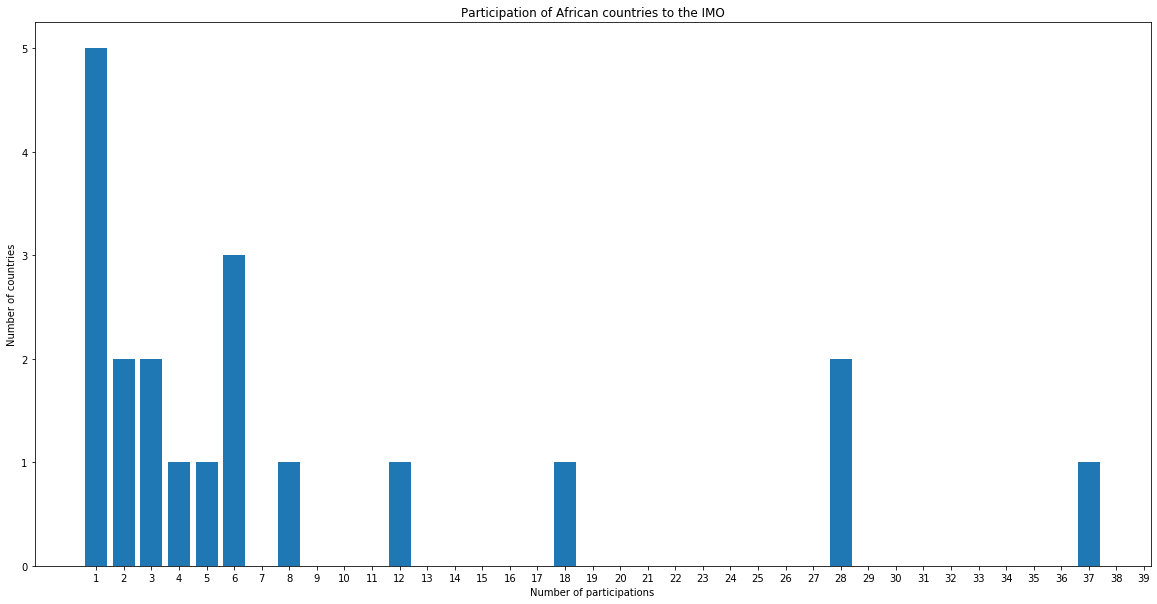

In [126]:
# Bar chart of number of participations of African countries

hist = [0 for i in range(len(african_participant))]

for a in range(len(african_participant)):
    hist[a] = data.shape[1] - sum(np.isnan(data[african_participant][a]))

u, inv = np.unique(hist, return_inverse=True)
counts = np.bincount(inv)

figure(figsize=(20,10))

plt.bar(u, counts) #, width=0.3

plt.xticks(np.arange(1,40))
plt.xlabel('Number of participations')
plt.ylabel('Number of countries')
plt.title('Participation of African countries to the IMO')
plt.show()

In [127]:
# Plot: for each African country, evolution of its performance at IMO

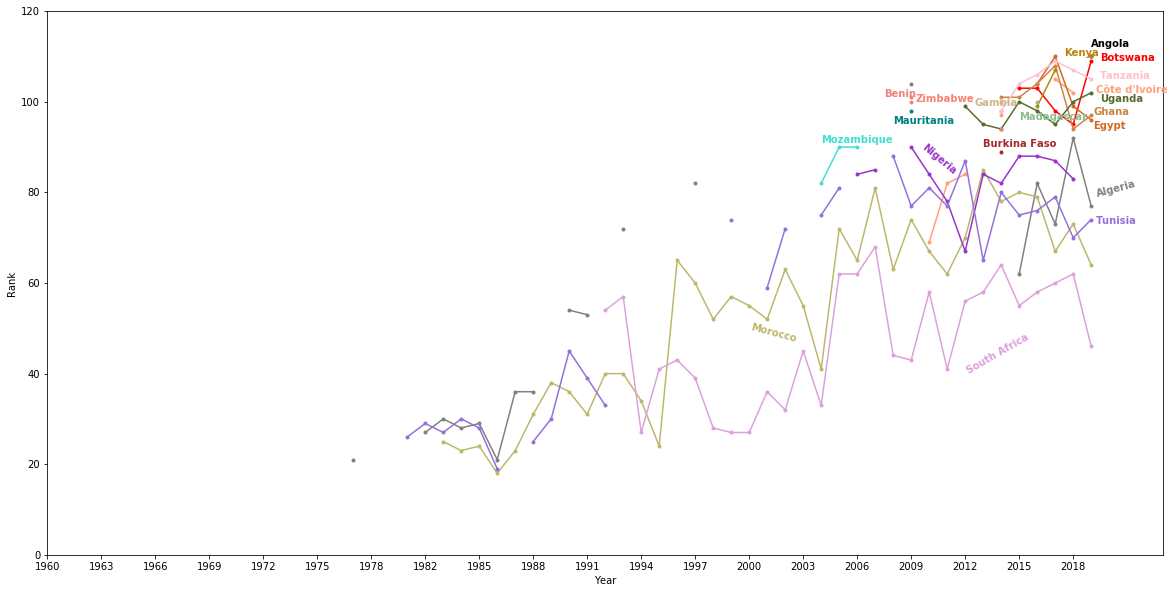

In [155]:
#colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS); colors # color names
mycolors = ['black','gray','lightcoral','brown','red','lightsalmon','chocolate','peru','tan','darkgoldenrod',
            'darkkhaki','darkseagreen','turquoise','teal','darkorchid','plum','mediumpurple','pink','darkolivegreen','salmon']

figure(figsize=(20,10))

for i in range(len(african_participant)):
    plt.plot(data[african_participant][i][::-1],'.-',color = mycolors[i],label=name[african_participant][i])
plt.ylim(0,np.nanmax(data[african_participant])+10)
plt.xlim(15,63)
plt.xlabel('Year')
plt.ylabel('Rank')

plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1])

plt.text(x = 59, y = data[african_participant][0][::-1][-1]+2, s = name[african_participant][0], color = mycolors[0], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][1][::-1][-1]+2, s = name[african_participant][1], color = mycolors[1], rotation = 15, weight = 'bold')
plt.text(x = 47.5, y = data[african_participant][2][::-1][54]+3, s = name[african_participant][2], color = mycolors[2], rotation = 0, weight = 'bold')
plt.text(x = 53, y = data[african_participant][3][::-1][-6]+1, s = name[african_participant][3], color = mycolors[3], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][4][::-1][-1], s = name[african_participant][4], color = mycolors[4], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][5][::-1][-2], s = name[african_participant][5], color = mycolors[5], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data[african_participant][6][::-1][-1]-2, s = name[african_participant][6], color = mycolors[6], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data[african_participant][7][::-1][-1], s = name[african_participant][7], color = mycolors[7], rotation = 0, weight = 'bold')
plt.text(x = 52.5, y = data[african_participant][8][::-1][-6]-1, s = name[african_participant][8], color = mycolors[8], rotation = 0, weight = 'bold')
plt.text(x = 57.5, y = data[african_participant][9][::-1][-1], s = name[african_participant][9], color = mycolors[9], rotation = 0, weight = 'bold')
plt.text(x = 40, y = data[african_participant][10][::-1][40]-8, s = name[african_participant][10], color = mycolors[10], rotation = -15, weight = 'bold')
plt.text(x = 55, y = data[african_participant][11][::-1][-4]-4, s = name[african_participant][11], color = mycolors[11], rotation = 0, weight = 'bold')
plt.text(x = 44, y = data[african_participant][12][::-1][-14]+1, s = name[african_participant][12], color = mycolors[12], rotation = 0, weight = 'bold')
plt.text(x = 48, y = data[african_participant][13][::-1][-11]-3, s = name[african_participant][13], color = mycolors[13], rotation = 0, weight = 'bold')
plt.text(x = 49.5, y = data[african_participant][14][::-1][-10], s = name[african_participant][14], color = mycolors[14], rotation = -40, weight = 'bold')
plt.text(x = 52, y = data[african_participant][15][::-1][-9]-1, s = name[african_participant][15], color = mycolors[15], rotation = 30, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][16][::-1][-1]-1, s = name[african_participant][16], color = mycolors[16], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][17][::-1][-1], s = name[african_participant][17], color = mycolors[17], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][18][::-1][-1]-2, s = name[african_participant][18], color = mycolors[18], rotation = 0, weight = 'bold')
plt.text(x = 49.25, y = data[african_participant][19][::-1][-11], s = name[african_participant][19], color = mycolors[19], rotation = 0, weight = 'bold');

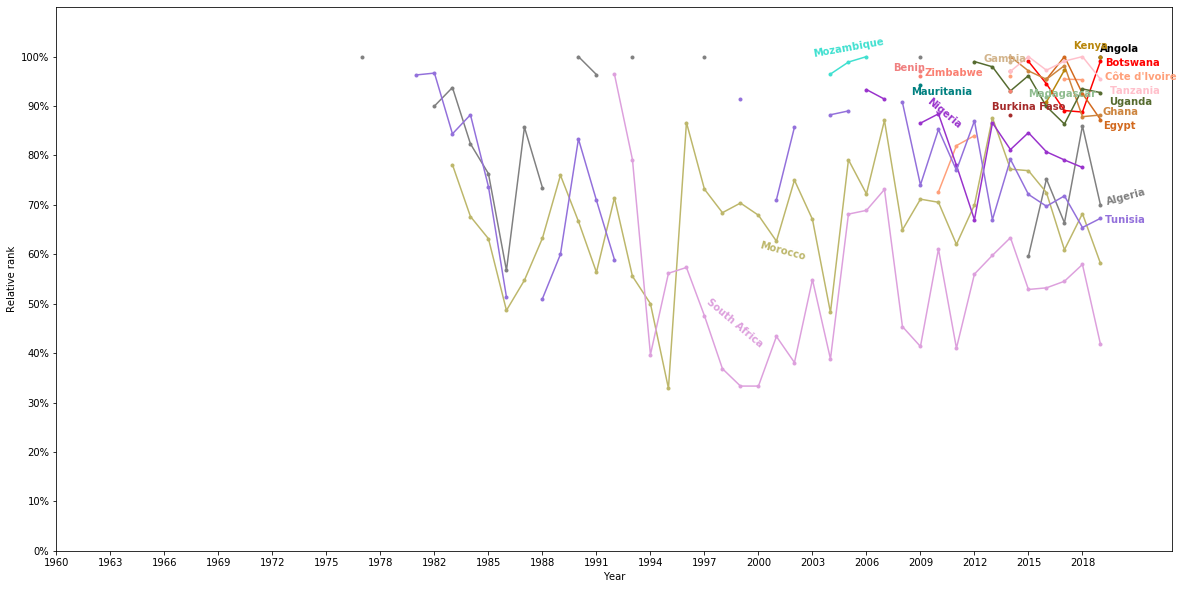

In [161]:
figure(figsize=(20,10))

for i in range(len(african_participant)):
    plt.plot(np.array(data_standardized)[african_participant][i][::-1],'.-',color = mycolors[i],label=np.array(name)[african_participant][i])

plt.ylim(0,1.1)
plt.xlim(15,63)
plt.xlabel('Year')
plt.ylabel('Relative rank')

plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1])
plt.yticks(np.arange(0,1.1,0.1),np.array(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']))

plt.text(x = 59, y = data_standardized[african_participant][0][::-1][-1]+0.01, s = name[african_participant][0], color = mycolors[0], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][1][::-1][-1], s = name[african_participant][1], color = mycolors[1], rotation = 15, weight = 'bold')
plt.text(x = 47.5, y = data_standardized[african_participant][2][::-1][54], s = name[african_participant][2], color = mycolors[2], rotation = 0, weight = 'bold')
plt.text(x = 53, y = data_standardized[african_participant][3][::-1][-6]+0.01, s = name[african_participant][3], color = mycolors[3], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][4][::-1][-1]-0.01, s = name[african_participant][4], color = mycolors[4], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][5][::-1][-2], s = name[african_participant][5], color = mycolors[5], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data_standardized[african_participant][6][::-1][-1]-0.02, s = name[african_participant][6], color = mycolors[6], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data_standardized[african_participant][7][::-1][-1], s = name[african_participant][7], color = mycolors[7], rotation = 0, weight = 'bold')
plt.text(x = 52.5, y = data_standardized[african_participant][8][::-1][-6], s = name[african_participant][8], color = mycolors[8], rotation = 0, weight = 'bold')
plt.text(x = 57.5, y = data_standardized[african_participant][9][::-1][-1]+0.015, s = name[african_participant][9], color = mycolors[9], rotation = 0, weight = 'bold')
plt.text(x = 40, y = data_standardized[african_participant][10][::-1][40]-0.09, s = name[african_participant][10], color = mycolors[10], rotation = -15, weight = 'bold')
plt.text(x = 55, y = data_standardized[african_participant][11][::-1][-4], s = name[african_participant][11], color = mycolors[11], rotation = 0, weight = 'bold')
plt.text(x = 43, y = data_standardized[african_participant][12][::-1][-14], s = name[african_participant][12], color = mycolors[12], rotation = 10, weight = 'bold')
plt.text(x = 48.5, y = data_standardized[african_participant][13][::-1][-11]-0.02, s = name[african_participant][13], color = mycolors[13], rotation = 0, weight = 'bold')
plt.text(x = 49.25, y = data_standardized[african_participant][14][::-1][-10]-0.03, s = name[african_participant][14], color = mycolors[14], rotation = -40, weight = 'bold')
plt.text(x = 37, y = data_standardized[african_participant][15][::-1][35]-0.15, s = name[african_participant][15], color = mycolors[15], rotation = -40, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][16][::-1][-1]-0.01, s = name[african_participant][16], color = mycolors[16], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data_standardized[african_participant][17][::-1][-1]-0.03, s = name[african_participant][17], color = mycolors[17], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data_standardized[african_participant][18][::-1][-1]-0.025, s = name[african_participant][18], color = mycolors[18], rotation = 0, weight = 'bold')
plt.text(x = 49.25, y = data_standardized[african_participant][19][::-1][-11], s = name[african_participant][19], color = mycolors[19], rotation = 0, weight = 'bold');

In [23]:
# # Map: for each African country, its best performance at IMO

# Help: https://medium.com/using-specialist-business-databases/creating-a-choropleth-map-using-geopandas-and-financial-data-c76419258746

In [25]:
# Import world shape map externally (no need to have a saved file)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# view first 5 rows
# world.head()

#inspect count
# world.info()

In [26]:
# merge both data sets using country name as identifiers

score = pd.DataFrame({'abs_rank':np.nanmin(data[african_participant],axis=1),
                      'rel_rank':np.nanmin(data_standardized[african_participant],axis=1)},
                     index=name[african_participant]); # consider working with DataFrames from the beginning

for_plotting = world.merge(score, left_on = 'name', right_index=True)
#for_plotting.info() #check the occurrence

C:\Users\djimd\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


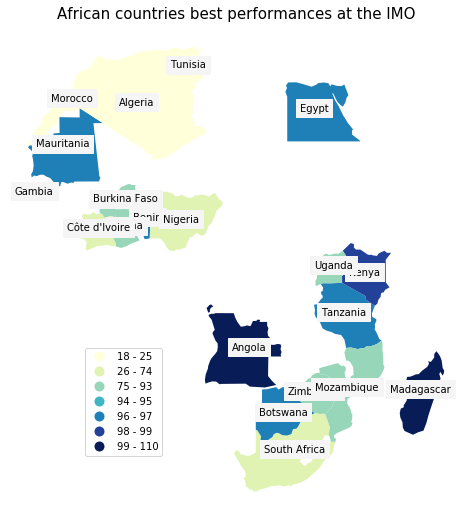

In [183]:
# Chloropeth Map

carte = for_plotting.plot(column='abs_rank', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 scheme='quantiles', k=7, legend =  
                                 True);
# Title
carte.set_title('African countries best performances at the IMO', fontdict={'fontsize':15});

# Remove axes
carte.set_axis_off();

#move legend to an empty space
carte.get_legend().set_bbox_to_anchor((.35,.35));
leg = carte.get_legend();
leg.get_texts()[0].set_text('18 - 25')
leg.get_texts()[1].set_text('26 - 74')
leg.get_texts()[2].set_text('75 - 93')
leg.get_texts()[3].set_text('94 - 95')
leg.get_texts()[4].set_text('96 - 97')
leg.get_texts()[5].set_text('98 - 99')
leg.get_texts()[6].set_text('99 - 110')
#carte.get_figure()

# Adding Labels (country names)

for_plotting['coords'] = for_plotting['geometry'].apply(lambda x: x.representative_point().coords)
for_plotting['coords'] = [coords[0] for coords in for_plotting['coords']]
for idx, row in for_plotting.iterrows():
    carte.annotate(s=row['name'], xy=row['coords'],horizontalalignment='center',backgroundcolor='whitesmoke') #
#carte.get_figure()